In [32]:
%load_ext autoreload
%autoreload 2
import torch
import eq
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
print(eq.data.default_catalogs_dir)

/home/gcl/RA/zekai.wang/recast/data


In [34]:
catalog = eq.catalogs.ANSS_MultiCatalog(num_sequences=10000,
    t_end_days=4*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,)

Loading existing catalog from /home/gcl/RA/zekai.wang/recast/data/ANSS_MultiCatalog.


In [35]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [300],
  arrival_times: [299],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [299],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Validation sequence:
Sequence(
  inter_times: [138],
  arrival_times: [137],
  t_start: 0.0,
  t_end: 843.909,
  t_nll_start: 0.0,
  mag: [137],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Test sequence:
Sequence(
  inter_times: [2445],
  arrival_times: [2444],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [2444],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)


<Axes: xlabel='Time (days)', ylabel='Magnitude'>

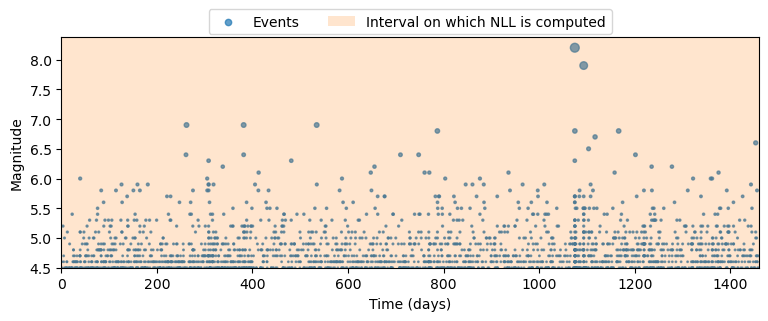

In [36]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True)

## Training the model

In [22]:
dl_train = catalog.train.get_dataloader(batch_size=32)
dl_val = catalog.val.get_dataloader(batch_size=32)
dl_test = catalog.test.get_dataloader(batch_size=32)

In [23]:
gpu_number = 2
device = torch.device(f"cuda:{gpu_number}")
print(f"using {device}")

using cuda:2


In [24]:
model = eq.models.RecurrentTPP()
model = model.to(device)

In [25]:
epochs = 100
avg_train_loss_list =[]
avg_val_loss_list = []

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

for epoch in trange(epochs):
    running_training_loss = []
    model.train()
    for i, data in enumerate(dl_train):
        data = data.to(device)
        optimizer.zero_grad()
        nll = model.nll_loss(data).mean()
        nll.backward()
        optimizer.step()
        running_training_loss.append(nll.item())
    
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        for i, data in enumerate(dl_val):
            data = data.to(device)
            nll = model.nll_loss(data).mean()
            running_val_loss.append(nll.item())

    avg_train_loss_list.append(np.mean(running_training_loss))
    avg_val_loss_list.append(np.mean(running_val_loss))

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
model.eval()
with torch.no_grad():
    running_test_loss = []
    for i, data in enumerate(dl_test):
        data = data.to(device)
        nll = model.nll_loss(data).mean()
        running_test_loss.append(nll.item())
print(f"avg test loss: {np.mean(running_test_loss)}")

avg test loss: 0.40023375314379495


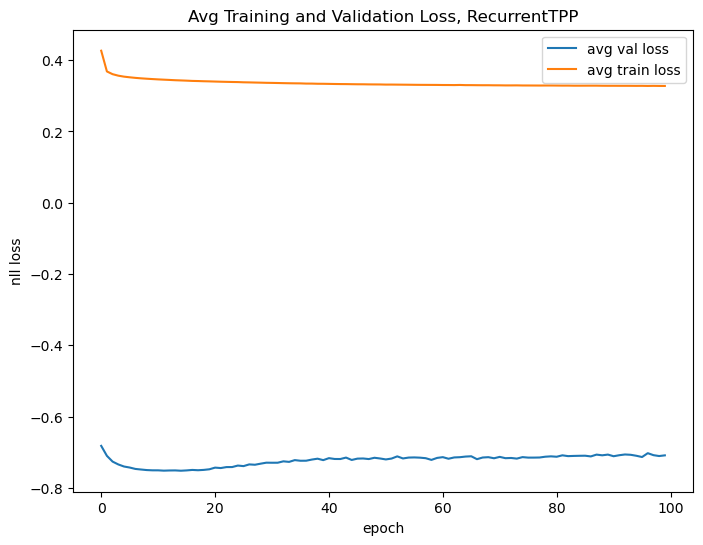

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(0, epochs), avg_val_loss_list, label="avg val loss")
ax.plot(np.arange(0, epochs), avg_train_loss_list, label="avg train loss")
ax.set_xlabel("epoch")
ax.set_ylabel("nll loss")
ax.legend()
ax.set_title("Avg Training and Validation Loss, RecurrentTPP")
plt.show()

In [26]:
torch.save(model, "trained_recurrent_tpp")